# Exercise 1
## Google Earth Engine and Cloud Computing

Google Earth Engine is an online tool which provides access to vast amounts of geospatial data, as well as infrastructure for working with that data. This means that Google hosts all of the large data sets without you having to download them. It also means that the expensive processing happens on their computers, and that you can do complex analysis on a small computer and without lots of internet bandwidth. 

For a list of available data sets on Google Earth Engine, you can visit this link: [https://developers.google.com/earth-engine/datasets](https://developers.google.com/earth-engine/datasets)

For a further introduction to Google Earth Engine, please see this link: [https://earthengine.google.com/](https://earthengine.google.com/)

In this exercise, we will use Google Earth Engine to access a long time series of satellite data for point locations. This is useful if you want to know how rainfall or temperature has changed in a specific location over a long point in time based on satellite data. 

To do this, we will use the Python computer language, which we can link to Google Earth Engine. There are detailed instructions on how to set this up [here](https://developers.google.com/earth-engine/python_install).

As an alternative, you can run all of the same analysis in [Google Colab](https://colab.research.google.com/). To do so, download this [file](https://github.com/tasmi/Workshop_Kathmandu_Feb2024/blob/main/Exercises/Day%201%20-%20Exercise%201%20-%20Climate%20Data%20for%20Specific%20Locations.ipynb) to your Google Colab instance. You can then follow the exercise in the same way as if you ran it on your own computer.

## Importing Python Modules

The first step to running any Python program is to import _modules_, which are small sets of commands that do specific tasks. In this exercise, we want to use three modules: 

1. [Google Earth Engine](https://github.com/google/earthengine-api)
2. [Matplotlib](https://matplotlib.org/)
3. [Numpy](https://numpy.org/)

These will provide us access to Google's servers, utilities for plotting data, and utilities for doing mathematical operations. 

To add modules to your Python program, use the _import_ line:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
import ee
#The first time you use the earthengine module, you need to link your account credentials. Afterwards, your
#computer stores the authentication file

#ee.Authenticate()

ee.Initialize()
print(ee.__version__)

0.1.379


Now that we have access to those Python modules, we can test if they are working and we can access Google's servers:

In [3]:
dem = ee.Image('USGS/SRTMGL1_003') #Load in the global SRTM elevation data set
xy = ee.Geometry.Point([86.9250, 27.9881]) #Define the location of interest
elev = dem.sample(xy, 30).first().get('elevation').getInfo() #Sample the data set at that point
print('Mount Everest elevation (m):', elev) #Print the result

Mount Everest elevation (m): 8729


Those four lines of code do a few steps:

1. Import the global SRTM Elevation data set at 30 m (see details [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003))
2. Choose a point location based on latitude and longitude, which is defined as a 'Point Geometry'
3. Sample the elevation data at 30 m resolution, and use _.getInfo()_ to download the result
4. Print the result

The important thing here is that no processing is done on your computer, and data is only downloaded when you use _.getInfo()_. This means you can do complex operations without having to download anyting but the final answer. We don't need to download the elevation data itself, we only want the elevation at a single point! Google Earth Engine takes care of the rest.

## Defining a Location of Interest

The main goal of this exercise is to choose a location of interest (for example, a glacier, a hydropower project, a weather station location, etc) and extract a time series of satellite measurements. The main benefit here is that we can skip the step of figuring out how to download, process, and sample very large data sets, and only concentrate on receiving the data we actually are interested in. In the second exercise today we will look at getting data over a larger area, but for now we will focus only on single point locations.

The easiest way to define a point location is with _latitude and longitude_, which you may already have from GPS measurements or known data about a climate station. Two easy alternative ways to get GPS coordinates is by using Google Maps or the website [geojson.io](https://geojson.io/). 

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Images/HotelKutumba.png" alt="" style="width: 600px;"/>

For example, if I right-click on the Google Maps location of our workshop location, I get a _latitude, longitude_ pair. This is the (Y, X) location we are on the globe!

We can use that directly to make a Google Earth Engine geometry, which we can then use to extract data. 

In [4]:
#NOTE THAT THIS IS [X, Y], and is opposite of the output from Google Maps!
hotel = ee.Geometry.Point([85.31634, 27.6825]) 
elev = dem.sample(hotel, 30).first().get('elevation').getInfo() #Sample the data set at that point
print('Hotel Kutumba elevation (m):', elev) #Print the result

Hotel Kutumba elevation (m): 1312


## Choosing Data 

There is a **massive** number of data sets we can choose from on Google Earth Engine. If we look at the [data catalog](https://developers.google.com/earth-engine/datasets), we can search for 'Climate' data as a first step:

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Images/ClimateData.png" alt="" style="width: 600px;"/>

Let's choose a simple rainfall data set: [CHIRPS Daily Precipitation](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)

This data covers the whole globe for the past 30+ years, and gives us daily total precipitation. We can add it to our Python script with the command:

In [5]:
rainfall = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
data_length = rainfall.size().getInfo()
print(data_length)

15736


This means we have more than 15000 days of precipitation data that we can access through that one line of Python code! That is a lot of data.

We can select a smaller subset, for example the last year by using a _filter_. 

In [6]:
rainfall = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate('2023-01-01', '2024-03-01') 
data_length = rainfall.size().getInfo()
print(data_length)

396


This is much shorter -- and will be easier to make a quick plot with. We can download the data using _sample_, as we did with elevation. However, this time we want to get **all of the values**, one for each time step.

In [7]:
def create_time_series(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=hotel).get('precipitation')
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), 'rainfall': value})
    return ft

time_series = rainfall.map(create_time_series).getInfo()

This gives us a long list of _dates_ and _values_ by going through each individual rainfall grid and sampling only at our 'hotel' location. However, it is not in a very nice data format -- we need to convert it into something a little nicer to work with.

In [8]:
time_series

{'type': 'FeatureCollection',
 'columns': {},
 'id': 'UCSB-CHG/CHIRPS/DAILY',
 'version': 1708050053397170.0,
 'properties': {'system:visualization_0_min': '1.0',
  'type_name': 'ImageCollection',
  'keywords': ['chg',
   'climate',
   'geophysical',
   'precipitation',
   'ucsb',
   'weather'],
  'thumb': 'https://mw1.google.com/ges/dd/images/CHIRPS_thumb.png',
  'description': '<p>Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)\nis a 30+ year quasi-global rainfall dataset. CHIRPS incorporates\n0.05° resolution satellite imagery with in-situ station data\nto create gridded rainfall time series for trend analysis and seasonal\ndrought monitoring.</p><p><b>Provider: <a href="https://chc.ucsb.edu/data/chirps">UCSB/CHG</a></b><br><p><b>Resolution</b><br>5566 meters\n</p><p><b>Cadence</b><br>\n  1 day\n</p><p><b>Bands</b><table class="eecat"><tr><th scope="col">Name</th><th scope="col">Description</th></tr><tr><td>precipitation</td><td><p>Precipitation</p></td></tr>

We can go through each item in the long list of data and extract only the pieces we are interested in -- the date and the amount of rainfall. We do this via a [for loop](https://www.w3schools.com/python/python_for_loops.asp). We can then print each value we extracted. 

In [9]:
for f in time_series['features']:
    properties = f['properties']
    date = properties['date']
    rain = properties['rainfall']
    print(date, rain)

2023/1/1 0
2023/1/2 0
2023/1/3 3.071701765060425
2023/1/4 0
2023/1/5 0
2023/1/6 2.4785475730895996
2023/1/7 0
2023/1/8 0
2023/1/9 0
2023/1/10 0
2023/1/11 0
2023/1/12 0
2023/1/13 0
2023/1/14 0
2023/1/15 0
2023/1/16 0
2023/1/17 0
2023/1/18 0
2023/1/19 0
2023/1/20 0
2023/1/21 0
2023/1/22 0
2023/1/23 0
2023/1/24 0
2023/1/25 0
2023/1/26 0
2023/1/27 0
2023/1/28 0
2023/1/29 0
2023/1/30 0
2023/1/31 0
2023/2/1 0
2023/2/2 0
2023/2/3 0
2023/2/4 0
2023/2/5 0
2023/2/6 0
2023/2/7 0
2023/2/8 0
2023/2/9 0
2023/2/10 0
2023/2/11 0
2023/2/12 0
2023/2/13 0
2023/2/14 0
2023/2/15 0
2023/2/16 0
2023/2/17 0
2023/2/18 0
2023/2/19 3.3546462059020996
2023/2/20 0
2023/2/21 0
2023/2/22 0
2023/2/23 0
2023/2/24 3.508694648742676
2023/2/25 0
2023/2/26 0
2023/2/27 0
2023/2/28 0
2023/3/1 0
2023/3/2 0
2023/3/3 0
2023/3/4 0
2023/3/5 0
2023/3/6 0
2023/3/7 0
2023/3/8 0
2023/3/9 0
2023/3/10 0
2023/3/11 0
2023/3/12 0
2023/3/13 2.1654653549194336
2023/3/14 2.1654653549194336
2023/3/15 0
2023/3/16 4.649045467376709
2023/3/17 0

We can also store each of these values in a list, so we can use them to make a simple plot:

In [10]:
dates, rainfalls = [], []
for f in time_series['features']:
    properties = f['properties']
    date = properties['date']
    rain = properties['rainfall']
    dates.append(datetime.datetime.strptime(date,'%Y/%m/%d')) #Convert the date into something that Python recognizes
    rainfalls.append(rain)

Text(0, 0.5, 'Daily Precipitation (mm/day)')

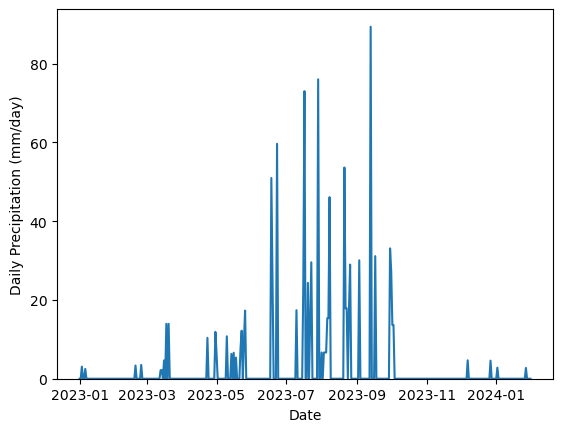

In [11]:
plt.plot(dates, rainfalls)
plt.ylim(ymin=0)
plt.xlabel('Date')
plt.ylabel('Daily Precipitation (mm/day)')

Let's compare that to the same time series from [http://www.mfd.gov.np/city?id=31](http://www.mfd.gov.np/city?id=31):

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Images/Rainfall_2023.png" alt="" style="width: 600px;"/>

We can add a vertical line marking the maximum rainfall day to make comparison easier:

89.40399169921875
[datetime.datetime(2023, 9, 13, 0, 0)]


Text(0, 0.5, 'Daily Precipitation (mm/day)')

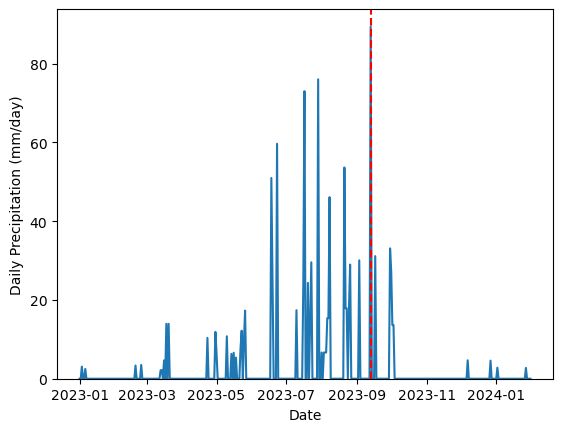

In [12]:
maximum_rainfall = np.array(rainfalls).max()
print(maximum_rainfall)
maximum_date = np.array(dates)[np.array(rainfalls) == maximum_rainfall]
print(maximum_date)

plt.plot(dates, rainfalls)
plt.ylim(ymin=0)
plt.axvline(maximum_date, 0, maximum_rainfall, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Daily Precipitation (mm/day)')

We can also look specically at the value for the largest rainfall day in the MFD data set (July 17):

In [13]:
july_17_rainfall = np.array(rainfalls)[np.array(dates) == datetime.datetime(2023, 7, 17, 0, 0)]
print(july_17_rainfall)

[73.03418732]


That is almost exactly the same as the MFD data! This is a nice confirmation that our data is useful. 

The main reason the data will differ is that the MFD data is for a single _point_, and the rainfall data from Google Earth Engine is a _grid_ which covers a relatively larger area (5 x 5 km). This means that the Earth Engine data integrates over a larger area, and doesn't always match perfectly with the single point station data. 

However, **not all locations have station data, and it is not always easy to get the data that does exist!** This means that we can instead use satellite data for some analyses -- especially in remote areas that are hard to reach and install monitoring stations.

## Looking at Multiple Types of Data

Let's choose another more remote location and acquire different types of data. For example, we can get rainfall, vegetation health, and snow-cover data all at once to compare their relationship.

I am going to use a point location near Langtang. Here is where I am choosing: 

<img src="https://raw.githubusercontent.com/tasmi/Workshop_Kathmandu_Feb2024/main/Images/Langtang.png" alt="" style="width: 600px;"/>

In [14]:
langtang = ee.Geometry.Point([85.51593, 28.21618]) 
elev = dem.sample(langtang, 30).first().get('elevation').getInfo() #Sample the data set at that point
print('Langtang elevation (m):', elev) #Print the result

Langtang elevation (m): 3544


Let's add the same rainfall data, as well as [temperature](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1) and [snow-cover](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD10A1).

In [15]:
rainfall = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate('2022-01-01', '2024-03-01') #Last two years
temperature = ee.ImageCollection("MODIS/061/MOD11A1").select('LST_Day_1km').filterDate('2022-01-01', '2024-03-01') #Last two years
veg_cover = ee.ImageCollection("MODIS/061/MOD13A2").select('NDVI').filterDate('2022-01-01', '2024-03-01') #Last two years

We can expand our 'create_time_series' function from above to sample different data for us:

In [16]:
def create_time_series(data, variable, name):
    def create_(image):
        date = image.get('system:time_start')
        value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=hotel).get(variable)
        ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), name: value})
        return ft
    return data.map(create_).getInfo() 

rain_series = create_time_series(rainfall, 'precipitation', 'rainfall')
temp_series = create_time_series(temperature, 'LST_Day_1km', 'temperature')
veg_series = create_time_series(veg_cover, 'NDVI', 'veg_cover')

Now convert it into something easier to plot:

In [17]:
def create_data(time_series, name):
    dates, datas = [], []
    for f in time_series['features']:
        properties = f['properties']
        date = properties['date']
        try:
            data = properties[name]
            datas.append(data)
            dates.append(datetime.datetime.strptime(date,'%Y/%m/%d')) #Convert the date into something that Python recognizes
        except:
            pass
    return np.array(dates), np.array(datas)

rdates, rain = create_data(rain_series, 'rainfall')
tdates, temp = create_data(temp_series, 'temperature')
vdates, veg = create_data(veg_series, 'veg_cover')

Text(0, 0.5, 'Daily Vegetation Greenness')

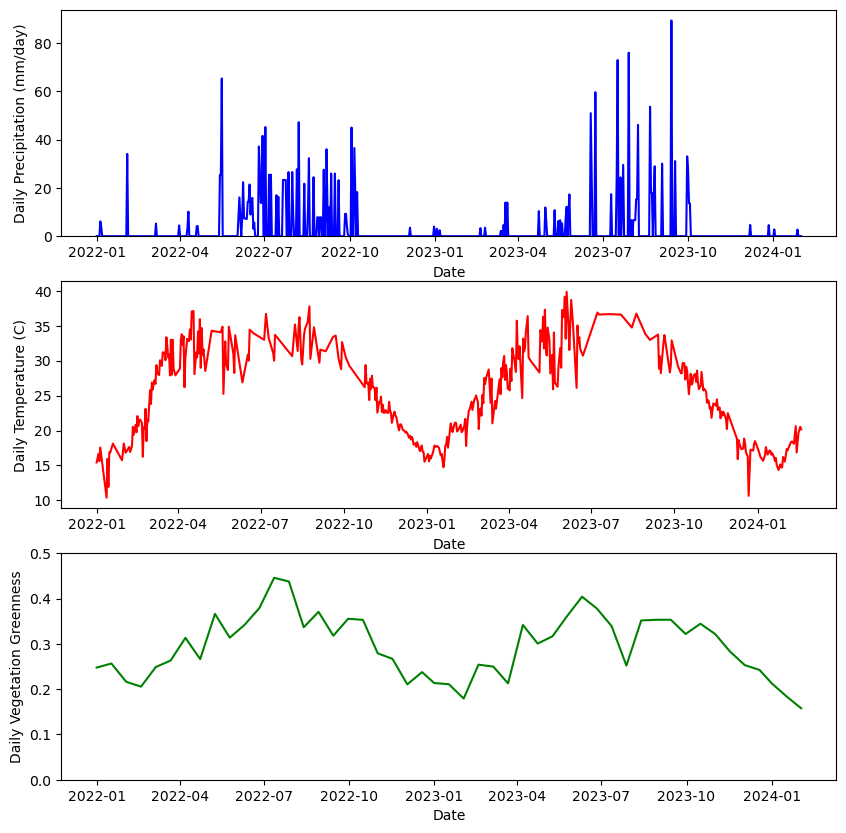

In [18]:
f, (ax, ax2, ax3) = plt.subplots(3, figsize=(10,10))

ax.plot(rdates, rain, 'b')
ax.set_ylim(ymin=0)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Precipitation (mm/day)')

#Note -- We need to convert temperature to celcius!
temp_c = temp*0.02 - 273.15
ax2.plot(tdates, temp_c, 'r')
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Temperature (C)')

#Note -- We need to rescale the NDVI data 
ax3.plot(vdates, veg *  0.0001, 'g')
ax3.set_ylim(0, 0.5)
ax3.set_xlabel('Date')
ax3.set_ylabel('Daily Vegetation Greenness')

## Further Information

This is a very simple way to pull data from satellites for specific locations. There are many data sets available on Google Earth Engine, covering many different environmental parameters. A full list can be found here: [https://developers.google.com/earth-engine/datasets](https://developers.google.com/earth-engine/datasets)

There are also many community data sets hosted here: [https://gee-community-catalog.org/](https://gee-community-catalog.org/) These include soil data, hydrological data, and climate data. Any of these data sets can be used the same way as we did in this example!

After the break, we will explore how to get larger data, for example covering an entire watershed, and how to make simple maps directly from that data. 

### Bonus: Downloading the Data to CSV

If you want to save the climate and environmental data that you create (for example, to open in Excel, or add to another data set), you can use Python as well. Since we already have the data downloaded as a list of dates and values, we can quickly write thme to a .csv file. The easiest way to do this is with [_pandas_](https://pandas.pydata.org/).

In [24]:
import pandas as pd

data = pd.DataFrame({'date':rdates, 'rainfall':rain})
print(data)

          date  rainfall
0   2022-01-01  0.000000
1   2022-01-02  0.000000
2   2022-01-03  0.000000
3   2022-01-04  0.000000
4   2022-01-05  6.119881
..         ...       ...
756 2024-01-27  2.745689
757 2024-01-28  0.000000
758 2024-01-29  0.000000
759 2024-01-30  0.000000
760 2024-01-31  0.000000

[761 rows x 2 columns]


<Axes: xlabel='date'>

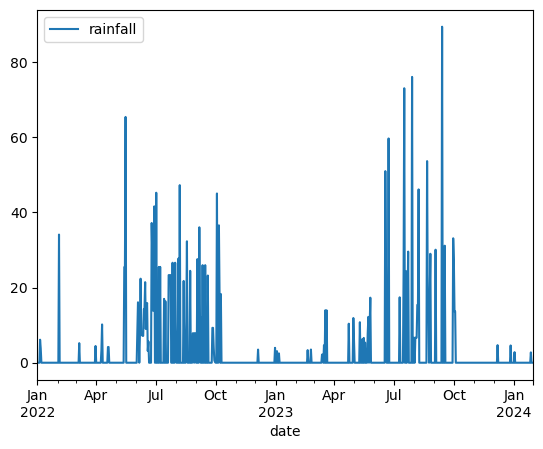

In [28]:
data.plot('date', 'rainfall')

This is a very easy way to work with time series data -- we will go more into this in the next exercises. For now, however, we can export our data with a simple command:

In [30]:
data.to_csv('Time Series/Kathmandu_Rainfall.csv', index=False)